# Workshop: Planning an Experiment
A power analysis is a process for deciding what sample size to use based on the chance of observing the minimum effect you are looking for in your study. This power analysis uses [DeclareDesign](http://declaredesign.org/) ([full documentation](https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf) is available on CRAN). Another option is the [egap Power Analysis page.](https://egap.org/content/power-analysis-simulations-r)

In the following example, we:
* establish *assumptions* about the experiment that we can *simulate*
* simulate the experiment N times
* *diagnose* the experiment design in light of our assumptions, for characteristics including:
  * statistical power (chance of observing a statistically-significant result)
  * bias in the results
  * (more below)
  
### The Scenario
Imagine you are designing an experiment where you want to test the effect of introducing images to Wikipedia biographies on the number of views that those biographies receive. 

As a pilot study, you have already queried a random sample of Wikipedia biographies (in this case in English) about women and men that do and do not have images. You have also conducted a simple statistical test to observe the correlation between having an image and the log-transformed number of views received by a biography (note: [this is a biased test](https://natematias.medium.com/estimating-counts-of-events-in-behavioral-product-testing-e3b68f6143e2), but we'll use it here for simplicity). You know that this is just a correlation— that pages with more views might be more likely to have images, either because greater attention leads to more edits, or because the social forces that led someone to receive more attention also led to public photographs being taken of the person. But it's still a good starting point for the upper bound of what an effect might be.

In this notebook, I illustrate how to carry out a power analysis using DeclareDesign, based on pilot data.


![Experiment card for Wikipedia biography experiment idea](wikipedia-biography-experiment-card.png)





In [90]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS) # includes rnegbin for generating negative binomial distributions
library(ggplot2)
library(rlang)
library(corrplot)
library(Hmisc)
library(tidyverse)
library(viridis)
library(fabricatr)
library(DeclareDesign)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))
options(repr.plot.width=7, repr.plot.height=4)


## Integer acquired from Brooklyn Integers on July 16, 2022
# https://brooklynintegers.com/int/1779899629/
set.seed(1779899629)

sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.15.7

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] DeclareDesign_0.13.0 estimatr_0.14        randomizr_0.16.1    
 [4] fabricatr_0.6.0      viridis_0.5.1        viridisLite_0.3.0   
 [7] forcats_0.3.0        stringr_1.3.1        purrr_0.3.4         
[10] readr_1.3.1          tidyr_0.8.2          tibble_3.0.1        
[13] tidyverse_1.2.1      Hmisc_4.2-0          Formula_1.2-3       
[16] survival_2.43-3      lattice_0.20-38      corrplot_0.84       
[19] rlang_0.4.6          ggplot2_3.1.0        MASS_7.3-51.1       
[22] dplyr_0.8.0.1       

l

# DeclareDesign Example
This example defines a simple difference in means experiment with two arms. 

The following dataframe sets some configuration characteristics that will be used throughout this document.

In [36]:
# config.df <- data.frame(
#     pa.label = "example.design",
#     n.max = 200,
#     n.min = 10,
    
#     y.mean.a    = 0,
#     y.sd.both   = 1,
#     y.effect.b  = 1
# )

config.df <- data.frame(
    pa.label = "example.design",
    n.max = 10000, #maximum participants in the study
    n.min = 1000,
    
    y.prob.a    = 0.005, # base rate
    y.effect.b  = 0.01 # enter the minimum meaningful or observable effect size
)

### Declare Population and Potential Outcomes
The first step is to declare the population and potential outcomes. This simulates example data for diagnosing your experiment. The underlying library for this is [fabricatr](https://declaredesign.org/r/fabricatr/).

The **population** in this case is the sample that is included in your experiment.

The **potential outcomes** are the columns for what outcome you *would* measure for each participant (or unit) if they received a given intervention. So if your experiment has two arms (treatment and control), you will have a potential outcome for each of those arms. 

Here, I use the convention VARIABLE_Z_N where VARIABLE is the name of the variable, Z is used by DeclareDesign as the treatment variable and N is the arm of the experiment for the given potential outcome. In this case YA is my variable. If the experiment had 10 arms, the potential outcomes would range from YA_Z_0 to YA_Z_9.

The **Design Summary** is a diagnostic output from DeclareDesign that explains to you what it is doing behind the scenes so you can confirm that it is actually doinng what you asked. It reports what was defined and then completes one simulation of the research design that you specified, reporting summary statistics for those variables. This is especially helpful when declaring potential outcomes, since you can review the summary statistics to make sure that the simulation is yielding variables with the characteristics you're seeking.

In [37]:
design <-
    declare_population(
        N = 100
    ) +
    declare_potential_outcomes(
        YA_Z_0 = rbinom(n=N, 1, config.df$y.prob.a),
        YA_Z_1 = rbinom(n=N, 1, config.df$y.prob.a + config.df$y.effect.b)
    )
design


Design Summary

Step 1 (population): declare_population(N = 100) -------------------------------

N = 100 

Added variable: ID 
 N_missing N_unique     class
         0      100 character

Step 2 (potential outcomes): declare_potential_outcomes(YA_Z_0 = rbinom(n = N, 1, config.df$y.prob.a),     YA_Z_1 = rbinom(n = N, 1, config.df$y.prob.a + config.df$y.effect.b)) 

Added variable: YA_Z_0 
    0
  100
 1.00

Added variable: YA_Z_1 
    0
  100
 1.00


### Declare Assignment
The next step is to declare the assignment/randomization approach. Here I use a simple randomization between two arms with a probability of 0.5. If you want to use a more complex randomization approach, you can combine DeclareDesign with [blockTools](https://cran.r-project.org/web/packages/blockTools/index.html), which some projects in this class may need.

Notice that DeclareDesign allows us to append new steps to the design as we go along.

In [38]:
design <- design +
    declare_assignment(num_arms = 2,
                       conditions = (c("0", "1")))

## show what the design includes at this stage
design


Design Summary

Step 1 (population): declare_population(N = 100) -------------------------------

N = 100 

Added variable: ID 
 N_missing N_unique     class
         0      100 character

Step 2 (potential outcomes): declare_potential_outcomes(YA_Z_0 = rbinom(n = N, 1, config.df$y.prob.a),     YA_Z_1 = rbinom(n = N, 1, config.df$y.prob.a + config.df$y.effect.b)) 

Added variable: YA_Z_0 
    0    1
   99    1
 0.99 0.01

Added variable: YA_Z_1 
    0    1
   99    1
 0.99 0.01

Step 3 (assignment): declare_assignment(num_arms = 2, conditions = (c("0", "1"))) 

Added variable: Z 
    0    1
   50   50
 0.50 0.50

Added variable: Z_cond_prob 
  0.5
  100
 1.00


### Declare the Estimand
The next step is to declare the **estimand**, the "true effect" that the experiment is estimating. Since, I pre-defined the estimand in the configuration dataframe and used it to calculate the potential outcomes, I know what the "true" effect should be. 

Each estimand needs a label, since we're going to compare the outcome of our estimates to the estimand to see how close they are. Here, I use the naming convention ate_VARIABLE_ARMB_ARMA. This is the estimand for the comparison of the average treatment effect(ate) between ARMA and ARMB. In an experiment with multiple arms and a control group, there would be multiple estimands and each of them would be compared to ARMA (ate_YA_1_0, ate_YA_2_0, ate_YA_3_0 etc). You could develop your own naming convention, but I find this one easy to skim.

In [39]:
design <- design + 
    declare_estimand(ate_YA_1_0 = config.df$y.effect.b)

## show what the design includes at this stage
design


Design Summary

Step 1 (population): declare_population(N = 100) -------------------------------

N = 100 

Added variable: ID 
 N_missing N_unique     class
         0      100 character

Step 2 (potential outcomes): declare_potential_outcomes(YA_Z_0 = rbinom(n = N, 1, config.df$y.prob.a),     YA_Z_1 = rbinom(n = N, 1, config.df$y.prob.a + config.df$y.effect.b)) 

Added variable: YA_Z_0 
    0
  100
 1.00

Added variable: YA_Z_1 
    0    1
   98    2
 0.98 0.02

Step 3 (assignment): declare_assignment(num_arms = 2, conditions = (c("0", "1"))) 

Added variable: Z 
    0    1
   50   50
 0.50 0.50

Added variable: Z_cond_prob 
  0.5
  100
 1.00

Step 4 (estimand): declare_estimand(ate_YA_1_0 = config.df$y.effect.b) ---------

A single draw of the estimand:
 estimand_label estimand
     ate_YA_1_0     0.01


### Declare the "Reveal"
Describe the process of assigning conditions and observing variables ([documentation for declare_reveal](https://www.rdocumentation.org/packages/DeclareDesign/versions/0.16.0/topics/declare_reveal)). This code can get complex, especially if there is **attrition** in your study (people not completing surveys, for example. Here, we assume that we can make an observation for every participant in the dataset.

Behind the scenes, this software creates a new column, YA, by choosing among the potential outcomes that we defined above. If we expect attrition in the study, this software would label columns where  we had incomplete data or the full procedure was not completed.

In [40]:
design <- design +
    declare_reveal(outcome_variables = c("YA"))
design


Design Summary

Step 1 (population): declare_population(N = 100) -------------------------------

N = 100 

Added variable: ID 
 N_missing N_unique     class
         0      100 character

Step 2 (potential outcomes): declare_potential_outcomes(YA_Z_0 = rbinom(n = N, 1, config.df$y.prob.a),     YA_Z_1 = rbinom(n = N, 1, config.df$y.prob.a + config.df$y.effect.b)) 

Added variable: YA_Z_0 
    0    1
   96    4
 0.96 0.04

Added variable: YA_Z_1 
    0    1
   98    2
 0.98 0.02

Step 3 (assignment): declare_assignment(num_arms = 2, conditions = (c("0", "1"))) 

Added variable: Z 
    0    1
   50   50
 0.50 0.50

Added variable: Z_cond_prob 
  0.5
  100
 1.00

Step 4 (estimand): declare_estimand(ate_YA_1_0 = config.df$y.effect.b) ---------

A single draw of the estimand:
 estimand_label estimand
     ate_YA_1_0     0.01

Step 5 (reveal): declare_reveal(outcome_variables = c("YA")) -------------------

Added variable: YA 
    0    1
   96    4
 0.96 0.04


### Declare the Estimator
Next, declare the estimator, the statistical test you will use to estimate the estimand from the observations that the experiment reveals. Here, I use a difference in means estimator (the equivalent of linear regression). Declare_design also makes it possible to write custom code for the estimator, as I do in [this example](https://github.com/natematias/poweranalysis-onlinebehavior/blob/master/Choosing-Sample-and-Estimators.ipynb).

In [41]:
design <- design +
    declare_estimator(YA ~ Z, estimand="ate_YA_1_0")
design


Design Summary

Step 1 (population): declare_population(N = 100) -------------------------------

N = 100 

Added variable: ID 
 N_missing N_unique     class
         0      100 character

Step 2 (potential outcomes): declare_potential_outcomes(YA_Z_0 = rbinom(n = N, 1, config.df$y.prob.a),     YA_Z_1 = rbinom(n = N, 1, config.df$y.prob.a + config.df$y.effect.b)) 

Added variable: YA_Z_0 
    0
  100
 1.00

Added variable: YA_Z_1 
    0    1
   98    2
 0.98 0.02

Step 3 (assignment): declare_assignment(num_arms = 2, conditions = (c("0", "1"))) 

Added variable: Z 
    0    1
   50   50
 0.50 0.50

Added variable: Z_cond_prob 
  0.5
  100
 1.00

Step 4 (estimand): declare_estimand(ate_YA_1_0 = config.df$y.effect.b) ---------

A single draw of the estimand:
 estimand_label estimand
     ate_YA_1_0     0.01

Step 5 (reveal): declare_reveal(outcome_variables = c("YA")) -------------------

Added variable: YA 
    0
  100
 1.00

Step 6 (estimator): declare_estimator(YA ~ Z, estimand = "at

### Diagnose the Design
To diagnose the design, you can simulate the research design and observe characteristics of the total research design in relation to your assumptions. This method generates and evaluates a total of `sims` versions of the experiment and reports the mean results for each of the following:

#### "Diagnosands" (results of the diagnosis)
* **Bias** Difference between the mean *estimate* and the *estimand*
* **RMSE** Root mean square error of the estimate sqrt(mean((estimate - estimand) ^ 2))
* **Coverage** Probability of confidence intervals including the *estimand*
* **Mean Estimate** The mean of all simulated *estimates*
* **SD Estimate** The standard deviation of all simulated *estimates*
* **Type S Rate** Probability of experiment to produce a statistically-significant result that is opposite in sign from the estimand
* **Mean Estimand** The mean of the *estimand*
* **Power** The probability of a statistically-significant result

In [42]:
diagnose_design(design, sims=500, bootstrap_sims=500)


Research design diagnosis based on 500 simulations. Diagnosand estimates with bootstrapped standard errors in parentheses (500 replicates).

 Design Label Estimand Label Estimator Label Term N Sims   Bias   RMSE Power
       design     ate_YA_1_0       estimator    Z    500  -0.00   0.02    NA
                                                         (0.00) (0.00)    NA
 Coverage Mean Estimate SD Estimate Mean Se Type S Rate Mean Estimand
       NA          0.01        0.02    0.01          NA          0.01
       NA        (0.00)      (0.00)  (0.00)          NA        (0.00)

# Conduct a Power Analysis

The simplest way to conduct a power analysis with DeclareDesign is to run a series of diagnoses at different sample sizes. That's what I do below with the method `iterate_for_power`:

* `diagnose.experiment` is a method that takes a sample size as an input and conducts a diagnosis from that  sample size
* `iterate.for.power` starts at `config.df$n.min` and sequentially adds `iteration.inteval` until `config.df$n.max` is reached and returns a dataframe containing the full results of every diagnosis


## Utility Methods

In [156]:
# Return the minimum power reported in a diagnosis
# 
#` @param diagnosis
min.diagnosis.power <- function(diagnosis){
    min(diagnosis$diagnosands_df['power'])
}


# CONSTRUCT A DIAGNOSIS
#
#' @param n.size     the sample size to test
#' @param config.df  the configuration dataframe to use 
#' @param sims.count the number of simulations to carry out
#' @param bootstrap.sims.count the number of bootstraps for estimating the simulation test statistics  

diagnose.experiment <- function(n.size, cdf, sims.count=500, bootstrap.sims.count=500){
    
    design <- declare_population(
        N = n.size
    ) +
    declare_potential_outcomes(
        YA_Z_0 = rbinom(n=N, 1, cdf$y.prob.a),
        YA_Z_1 = rbinom(n=N, 1, cdf$y.prob.a + cdf$y.effect.b)
    ) +
    declare_assignment(num_arms = 2,
                       conditions = (c("0", "1"))) +
    declare_estimand(ate_YA_1_0 = cdf$y.effect.b) +
    declare_reveal(outcome_variables = c("YA")) +
    declare_estimator(YA ~ Z, estimand="ate_YA_1_0")
    
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                 bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

In [44]:
# Iterate linearly for a certain level of statistical power
# within the constraints of a configuration file
# at a certain sample size increment. Useful for
# illustrating ideas, or for comparing estimators with
# very different statistical power, where the binary search
# will optimize for the worst estimator but not show useful
# indormation about more efficient estimators
#
#` @param config.df The configuration file in question
#` @diagnosis.method The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @iteration.interval when iterating, use this interval between sample sizes

iterate.for.power <- function(config.df, diagnosis.method = diagnose.experiment, 
                             iteration.interval){  
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    current.sample.size = min.sample.size
    
    iteration.count = ceiling((max.sample.size - min.sample.size) / iteration.interval)

    ## Initialize first iteration
    print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
    flush.console()

    ptm = proc.time()
    ddf <- diagnosis.method(current.sample.size, config.df)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)
    time.elapsed <- proc.time() -  ptm
    print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    
    for(i in seq(1, iteration.count)){
        current.sample.size = current.sample.size + iteration.interval
        print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
        flush.console()
    
        ptm = proc.time()
        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, config.df)
        ddf$diagnosands$n <- current.sample.size
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
        time.elapsed <- proc.time() -  ptm
        print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    }
    diagnoses.df
}

In [45]:
# Create a plot of a power search or iteration output
# Especially useful in cases with multiple DVs or models
#
#' @param diagnoses Dataframe of diagnosis info
#` @param config.df the power analysis config dataframe

plot.power.results <- function(diagnoses, config.df){
    for(estimator_label in unique(diagnoses$estimator_label)){
        estimator.diagnoses <- diagnoses[diagnoses$estimator_label==estimator_label,]
        estimator_min_sample = min(estimator.diagnoses$n[estimator.diagnoses$power>0.8])
        p <- ggplot(data=estimator.diagnoses, aes(n, power)) +
                geom_point(color="coral") +
                xlab("sample size") +
                ylim(0,1) +
                geom_hline(aes(yintercept=0.8), linetype="dashed") +
                theme_light() +
                ggtitle(paste(config.df$pa.label, ": statistical Power for Estimator ", estimator_label, "\n",
                              "Minimum sample: ", estimator_min_sample, sep="")) +
                ggsave(paste("figures/power.analysis.", make.names(estimator_label), ".", config.df$pa.label, ".png", sep=""))
    }
}



# Conduct Power Analysis
In this code, we simulate the experiment at different sample sizes and plot the diagnosands by sample size. As currently configured, this will run 500 simulations of the experiment design we specified at increasing sample sizes (10 more each time) until it gets to a sample size of 200. 

In total, this code will run 500 * (200 - 10)/10 = 9500 simulations. 

Since this can take a while. I use [beepr](https://www.r-project.org/nosvn/pandoc/beepr.html) to let me know that the power analysis is [complete](https://www.youtube.com/watch?v=69AyYUJUBTg). (The times reported here are from my 2018 MacBook Pro with 16GB of RAM and 2.3GHz Intel Core i5). This process could be sped up with the [doParallel](https://cran.r-project.org/web/packages/doParallel/vignettes/gettingstartedParallel.pdf) library, which would take advantage of more than one core when conducting a power analysis.

SOC412 students: if this or any other power analysis is taking more than 15 minutes on your own computer, let me know, and I will work with you to find the required computing resources.

In [157]:
interval = 1000
power.iterate.df <- iterate.for.power(config.df, iteration.interval = interval)
#beep(sound="treasure")

[1] "min: 1000 max: 10000 current: 1000"
[1] "     seconds: 9"
[1] "min: 1000 max: 10000 current: 2000"
[1] "     seconds: 9"
[1] "min: 1000 max: 10000 current: 3000"
[1] "     seconds: 11"
[1] "min: 1000 max: 10000 current: 4000"
[1] "     seconds: 13"
[1] "min: 1000 max: 10000 current: 5000"
[1] "     seconds: 14"
[1] "min: 1000 max: 10000 current: 6000"
[1] "     seconds: 16"
[1] "min: 1000 max: 10000 current: 7000"
[1] "     seconds: 17"
[1] "min: 1000 max: 10000 current: 8000"
[1] "     seconds: 18"
[1] "min: 1000 max: 10000 current: 9000"
[1] "     seconds: 24"
[1] "min: 1000 max: 10000 current: 10000"
[1] "     seconds: 22"


### Plot Statistical Power

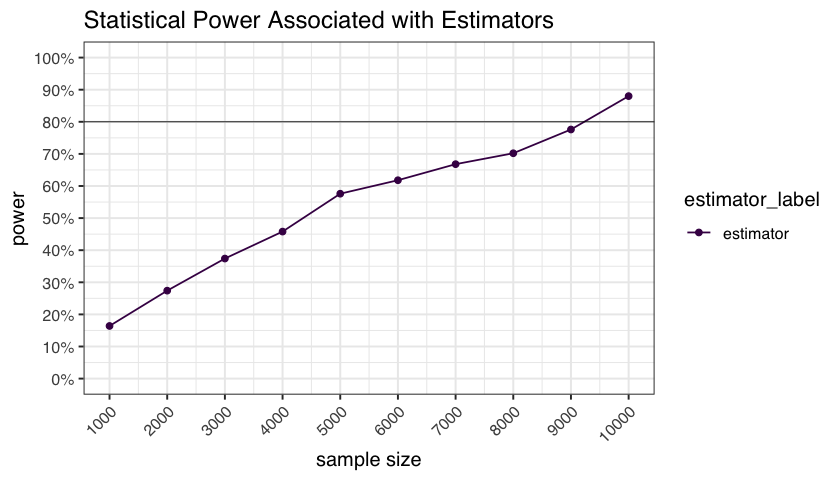

In [138]:
ggplot(power.iterate.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(config.df$n.min,config.df$n.max+10,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

### Plot Estimator Bias

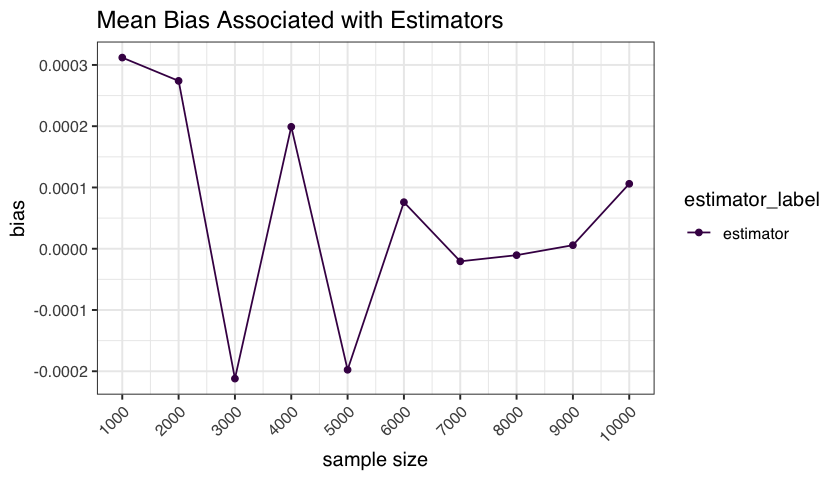

In [158]:
ggplot(power.iterate.df, aes(n, bias, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(config.df$n.min,config.df$n.max+10,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Bias Associated with Estimators")

### Plot Confidence Interval Coverage

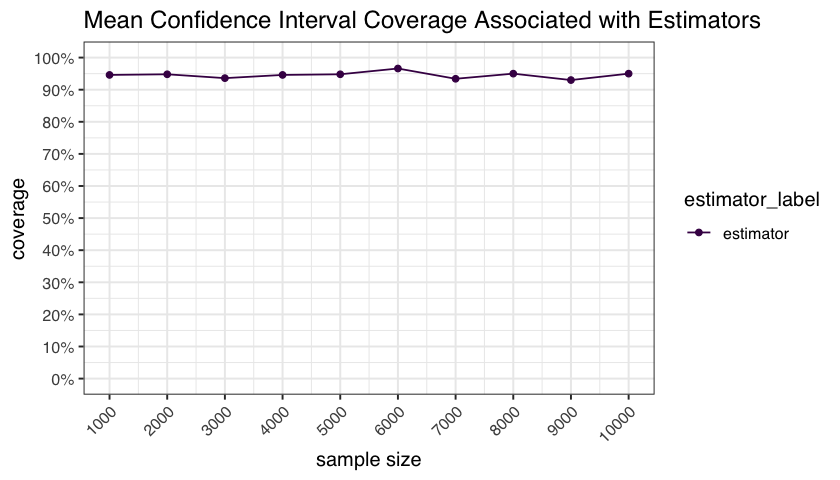

In [159]:
ggplot(power.iterate.df, aes(n, coverage, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(config.df$n.min,config.df$n.max+10,interval)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Confidence Interval Coverage Associated with Estimators")

### Plot Type S Rate

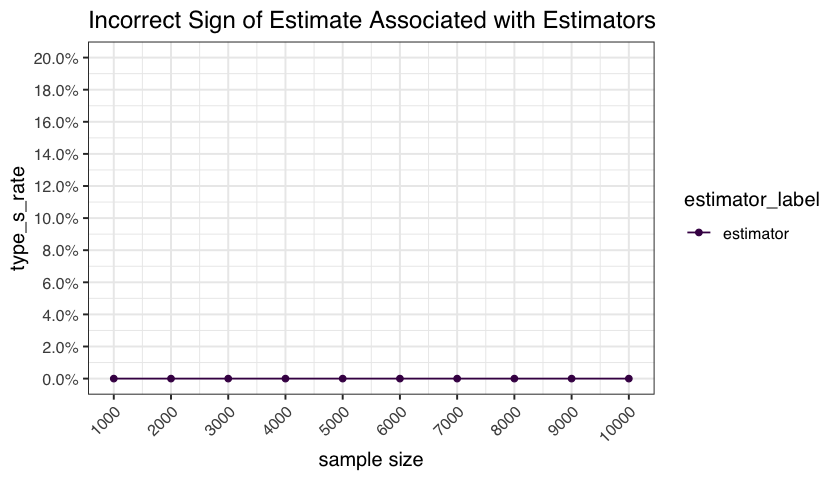

In [160]:
ggplot(power.iterate.df, aes(n, type_s_rate, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(config.df$n.min,config.df$n.max+10,interval)) +
    scale_y_continuous(breaks = seq(0,0.2,0.02), limits = c(0,0.2), labels=scales::percent) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Incorrect Sign of Estimate Associated with Estimators")

# Work through Example from Wikipedia

To start, I develop a model that can be used for estimating my initial parameters for the simulation. So I test the hypothesis of a correlation between the log-transformed number of views in June 2022 and whether the article has any images or not, controlling for other factors such as gender, article length, and page quality.


In [206]:
# Return the difference in mu associated with an incidence rate ratio
# from a negative binomial model. This difference can then be used to
# simulate a negative binomial distribution for the effect of a given irr
#                                                                       
#` @param mu The baseline mu in question                               
#` @param irr The incidence rate ratio in question
mu.diff.from.mu.irr <- function(mu, irr){
    return(mu*(irr-1))
}

In [142]:
#summary(glm.nb(views_2022050100 ~ any_image, data=pilot.df))
colnames(pilot.df)
pilot.df <- read.csv("2022-07-15-view-list.csv")
pilot.df$log2p_pageQuality_enwiki <- log(pilot.df$pageQuality_enwiki+2)
#summary(is.infinite(pilot.df$log2p_pageQuality_enwiki))


[1] "X"                        "views"                   
 [3] "start_date"               "end_date"                
 [5] "wiki"                     "gender"                  
 [7] "imagecount"               "url"                     
 [9] "peopleID"                 "genderNames"             
[11] "occupationNames"          "ethnicity"               
[13] "religion"                 "citizenshipNames"        
[15] "position"                 "birthplace"              
[17] "birthCountry"             "birthContinent"          
[19] "occupationType"           "locationIDs"             
[21] "zhwiki"                   "enwiki"                  
[23] "hiwiki"                   "eswiki"                  
[25] "ruwiki"                   "arwiki"                  
[27] "ptwiki"                   "bnwiki"                  
[29] "frwiki"                   "idwiki"                  
[31] "quality_zhwiki"           "quality_enwiki"          
[33] "quality_hiwiki"           "quality_eswiki"          
[35] "quality_ruwiki"           "quality_arwiki"          
[37] "quality_ptwiki"           "quality_bnwiki"          
[39] "quality_frwiki"           "quality_idwiki"          
[41] "numLangPage"              "pageID_zhwiki"           
[43] "pageID_enwiki"            "pageID_hiwiki"           
[45] "pageID_eswiki"            "pageID_ruwiki"           
[47] "pageID_arwiki"            "pageID_ptwiki"           
[49] "pageID_bnwiki"            "pageID_frwiki"           
[51] "pageID_idwiki"            "pageLength_zhwiki"       
[53] "pageLength_enwiki"        "pageLength_hiwiki"       
[55] "pageLength_eswiki"        "pageLength_ruwiki"       
[57] "pageLength_arwiki"        "pageLength_ptwiki"       
[59] "pageLength_bnwiki"        "pageLength_frwiki"       
[61] "pageLength_idwiki"        "pageQuality_enwiki"      
[63] "pageQuality_zhwiki"       "pageQuality_hiwiki"      
[65] "pageQuality_eswiki"       "pageQuality_ruwiki"      
[67] "pageQuality_arwiki"       "pageQuality_ptwiki"      
[69] "pageQuality_bnwiki"       "pageQuality_frwiki"      
[71] "pageQuality_idwiki"       "views_2022010100"        
[73] "views_2022020100"         "views_2022030100"        
[75] "views_2022040100"         "views_2022050100"        
[77] "log1p_views"              "any_image"               
[79] "log1p_pageLength_enwiki"  "log1p_views_2022040100"  
[81] "log1p_views_2022010100"   "log1p_views_2022050100"  
[83] "log1p_views_2022020100"   "log1p_views_2022030100"  
[85] "log2p_pageQuality_enwiki"

In [165]:
summary(pilot.df$any_image)

False  True 
 3000  3000

In [171]:
fitdistr(subset(pilot.df, any_image=="False" & is.na(views_2022050100)!=TRUE)$views_2022050100, 
         densfun="negative binomial")

Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”
Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”


      size          mu    
    0.329219   438.012870 
 (  0.006958) ( 14.240333)

In [180]:

summary(m1 <- glm.nb(views_2022050100 ~ any_image + gender + 
                     pageLength_enwiki +
                     occupationType, 
           data=pilot.df,
           na.action=na.exclude))


m1.intercept <- summary(m1)$coefficients['(Intercept)',][['Estimate']]
m1.image_coef.irr <- exp(summary(m1)$coefficients['any_imageTrue',][['Estimate']])
m1.theta <- summary(m1)$theta
# paste("Intercept in the model:", prettyNum(intercept))
# paste("Average estimated views per month per bio in the model:", prettyNum(exp(intercept)-1))
# paste("Coefficient for any_image in the model:", prettyNum(image_coef))
# paste("Views per month greater for bios with an image, on average:",
#      prettyNum(exp(intercept+image_coef) - exp(intercept)))


Call:
glm.nb(formula = views_2022050100 ~ any_image + gender + pageLength_enwiki + 
    occupationType, data = pilot.df, na.action = na.exclude, 
    init.theta = 0.3964707066, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.287  -1.210  -0.848  -0.335  11.681  

Coefficients:
                                      Estimate  Std. Error z value
(Intercept)                         5.56150243  0.17320135   32.11
any_imageTrue                       0.57696408  0.04664645   12.37
gendermale                         -0.43390310  0.04679943   -9.27
pageLength_enwiki                   0.00010550  0.00000207   50.90
occupationTypeArts                  0.66030716  0.17191612    3.84
occupationTypeBusiness              0.17690055  0.22734123    0.78
occupationTypeGovernment           -0.56110287  0.17621896   -3.18
occupationTypeHumanities           -0.17249703  0.18761493   -0.92
occupationTypeLaw                  -0.57673006  0.22915726   -2.52
occupationTypeOther  

In [199]:
f1 <- fitdistr(subset(pilot.df, any_image=="False" & is.na(views_2022050100)!=TRUE)$views_2022050100, 
         densfun="negative binomial")

Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”
Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”


### Construct a Diagnosis

In [226]:

wikipedia.config.df <- data.frame(
    pa.label = "example.design",
    n.max = 1000, #maximum participants in the study
    n.min = 100,
    
#    y.theta     = m1.theta,      # distribution shape
    y.intercept  = m1.intercept, 
    y.mu         = f1$estimate[['mu']],
    y.theta      = f1$estimate[['size']],
    y.effect.irr = m1.image_coef.irr  # enter the minimum meaningful or observable effect size
)

In [220]:


# CONSTRUCT A DIAGNOSIS
#
#' @param n.size     the sample size to test
#' @param config.df  the configuration dataframe to use 
#' @param sims.count the number of simulations to carry out
#' @param bootstrap.sims.count the number of bootstraps for estimating the simulation test statistics  

diagnose.wikipedia.experiment <- function(n.size, cdf, sims.count=500, bootstrap.sims.count=500){
    
    design <- declare_population(
        N = n.size
    ) +
    declare_potential_outcomes(
        YA_Z_0 = rnegbin(n.size, mu=cdf$y.mu, theta=cdf$y.theta),
        YA_Z_1 = rnegbin(n.size, mu=cdf$y.mu + mu.diff.from.mu.irr(cdf$y.mu, cdf$y.effect.irr), theta=cdf$y.theta)
    ) +
    declare_assignment(num_arms = 2,
                       conditions = (c("0", "1"))) +
    declare_estimand(ate_YA_1_0 = log(cdf$y.effect.irr)) +
    declare_reveal(outcome_variables = c("YA")) +
    declare_estimator(YA ~ Z, model=glm.nb, estimand="ate_YA_1_0")
    
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                 bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

In [221]:
diagnose.wikipedia.experiment(1000,wikipedia.config.df)


Research design diagnosis based on 500 simulations. Diagnosand estimates with bootstrapped standard errors in parentheses (500 replicates).

 Design Label Estimand Label Estimator Label Term N Sims   Bias   RMSE  Power
       design     ate_YA_1_0       estimator   Z1    500   0.00   0.11   1.00
                                                         (0.00) (0.00) (0.00)
 Coverage Mean Estimate SD Estimate Mean Se Type S Rate Mean Estimand
     0.95          0.58        0.11    0.11        0.00          0.58
   (0.01)        (0.00)      (0.00)  (0.00)      (0.00)        (0.00)

In [237]:
interval = 100
power.iterate.wp.df <- iterate.for.power(wikipedia.config.df, 
                                      diagnosis.method = diagnose.wikipedia.experiment,
                                      iteration.interval = interval)
#beep(sound="treasure")

[1] "min: 100 max: 1000 current: 100"
[1] "     seconds: 17"
[1] "min: 100 max: 1000 current: 200"
[1] "     seconds: 18"
[1] "min: 100 max: 1000 current: 300"
[1] "     seconds: 18"
[1] "min: 100 max: 1000 current: 400"
[1] "     seconds: 21"
[1] "min: 100 max: 1000 current: 500"
[1] "     seconds: 23"
[1] "min: 100 max: 1000 current: 600"
[1] "     seconds: 35"
[1] "min: 100 max: 1000 current: 700"
[1] "     seconds: 30"
[1] "min: 100 max: 1000 current: 800"
[1] "     seconds: 36"
[1] "min: 100 max: 1000 current: 900"
[1] "     seconds: 36"
[1] "min: 100 max: 1000 current: 1000"
[1] "     seconds: 46"


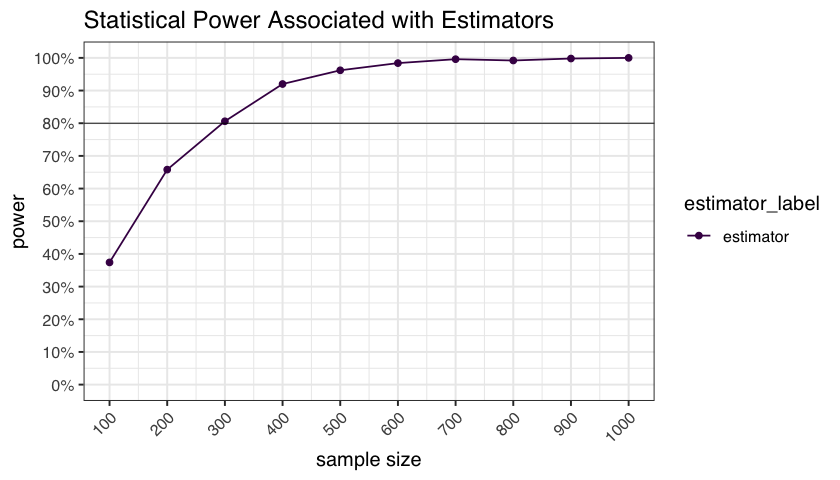

In [238]:
ggplot(power.iterate.wp.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(wikipedia.config.df$n.min,wikipedia.config.df$n.max+10,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

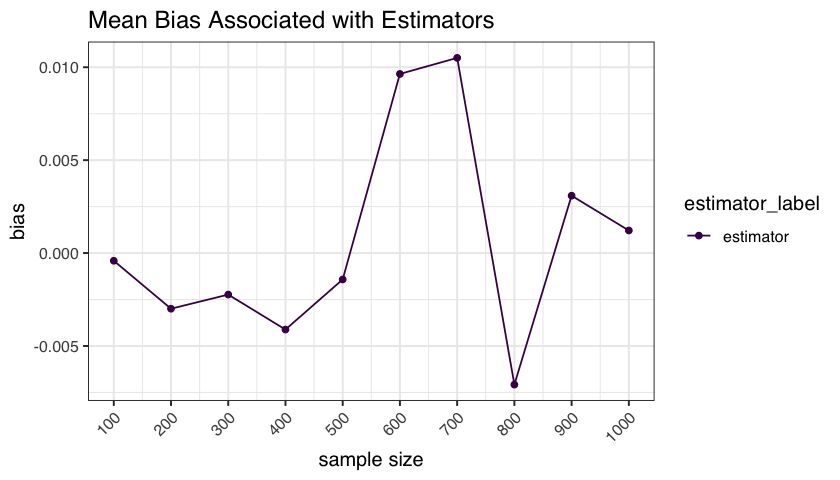

In [239]:
ggplot(power.iterate.wp.df, aes(n, bias, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(wikipedia.config.df$n.min,wikipedia.config.df$n.max+10,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Bias Associated with Estimators")

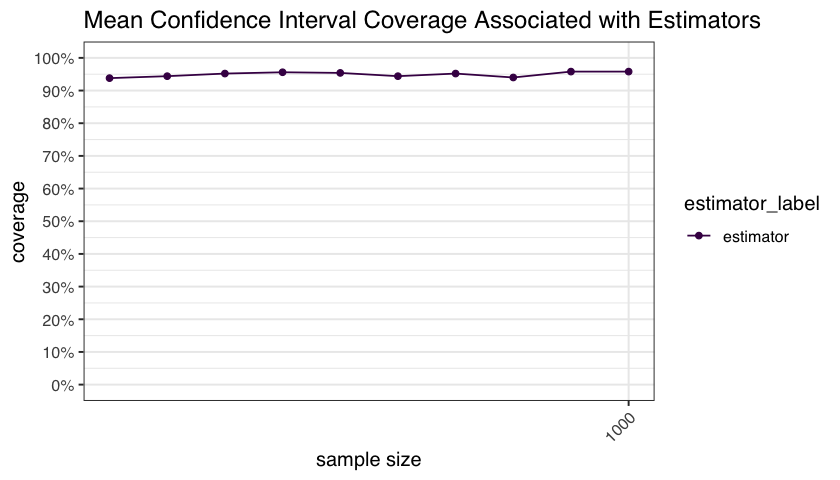

In [240]:
ggplot(power.iterate.wp.df, aes(n, coverage, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(config.df$n.min,config.df$n.max+10,interval)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Confidence Interval Coverage Associated with Estimators")

### Now rerun the power analysis with a smaller minimum meaningful/observable effect size
In this study, we want to be able to observe effects that are smaller than the correlation we observed, so it's important to choose a minimum observable effect size that is smaller. In the ideal world, we identify a number that is the cutoff at which any effect would be too small to be meaningful for science, or too small to be practically valuable to the community.

In [246]:

wikipedia.config.min.df <- data.frame(
    pa.label = "example.design",
    n.max = 3000, #maximum participants in the study
    n.min = 1000,
    
#    y.theta     = m1.theta,      # distribution shape
    y.intercept  = m1.intercept, 
    y.mu         = f1$estimate[['mu']],
    y.theta      = f1$estimate[['size']],
    y.effect.irr = 1.25  # enter the minimum meaningful or observable effect size
)

In [247]:
interval = 200
power.iterate.wp.min.df <- iterate.for.power(wikipedia.config.min.df, 
                                      diagnosis.method = diagnose.wikipedia.experiment,
                                      iteration.interval = interval)
#beep(sound="treasure")

[1] "min: 1000 max: 3000 current: 1000"
[1] "     seconds: 36"
[1] "min: 1000 max: 3000 current: 1200"
[1] "     seconds: 44"
[1] "min: 1000 max: 3000 current: 1400"
[1] "     seconds: 50"
[1] "min: 1000 max: 3000 current: 1600"
[1] "     seconds: 50"
[1] "min: 1000 max: 3000 current: 1800"
[1] "     seconds: 55"
[1] "min: 1000 max: 3000 current: 2000"
[1] "     seconds: 58"
[1] "min: 1000 max: 3000 current: 2200"
[1] "     seconds: 66"
[1] "min: 1000 max: 3000 current: 2400"
[1] "     seconds: 66"
[1] "min: 1000 max: 3000 current: 2600"
[1] "     seconds: 83"
[1] "min: 1000 max: 3000 current: 2800"
[1] "     seconds: 85"
[1] "min: 1000 max: 3000 current: 3000"
[1] "     seconds: 86"


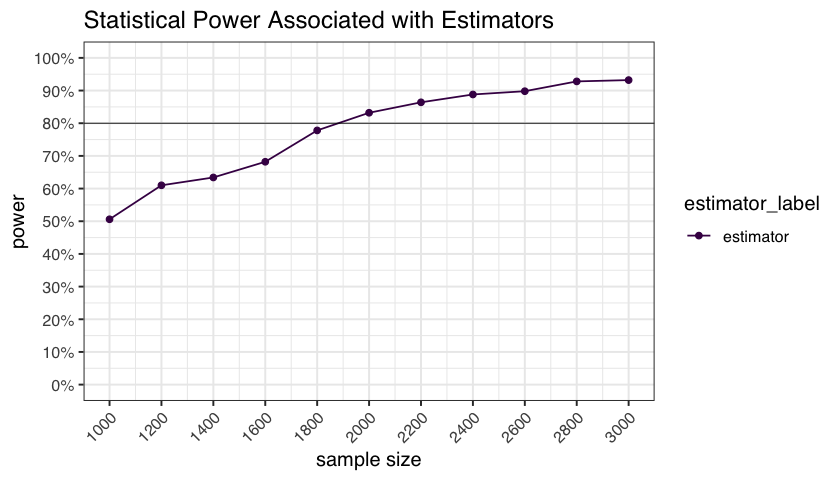

In [248]:
ggplot(power.iterate.wp.min.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(wikipedia.config.min.df$n.min,wikipedia.config.min.df$n.max+10,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

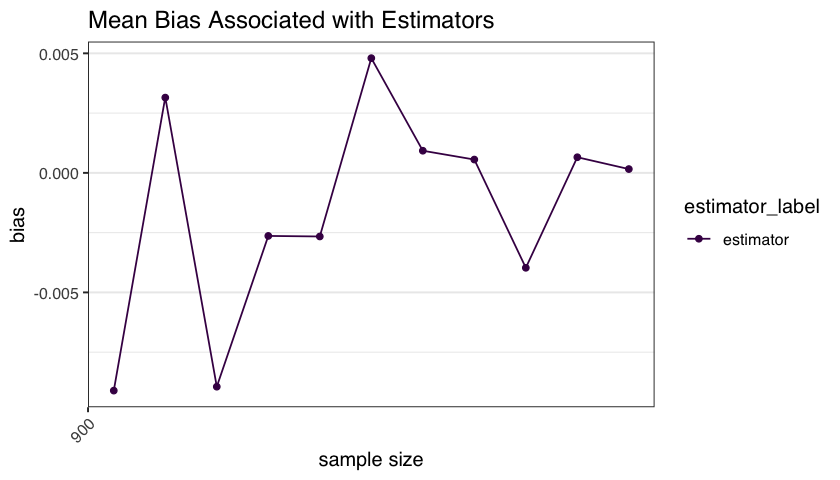

In [250]:
ggplot(power.iterate.wp.min.df, aes(n, bias, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(wikipedia.config.df$n.min,wikipedia.config.df$n.max+10,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Bias Associated with Estimators")

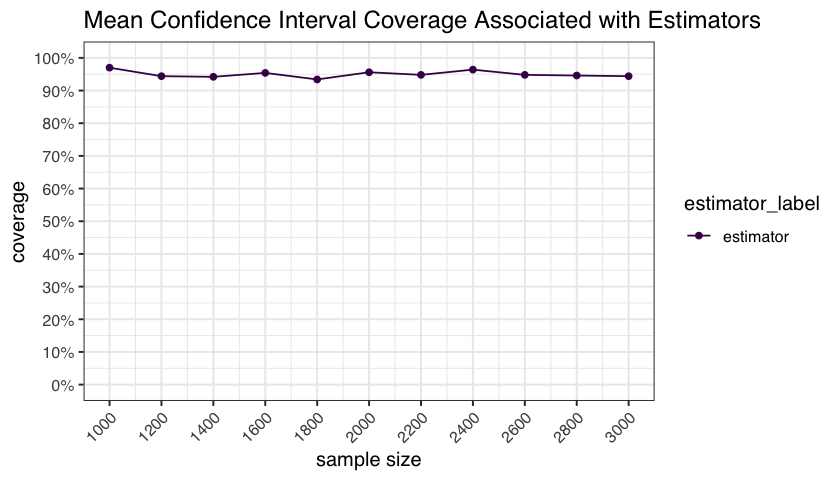

In [249]:
ggplot(power.iterate.wp.min.df, aes(n, coverage, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(config.df$n.min,config.df$n.max+10,interval)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Confidence Interval Coverage Associated with Estimators")